In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit import RDPaths

import dgl
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from dgl import model_zoo

from dgl.data.chem.utils import mol_to_complete_graph, mol_to_bigraph

from dgl.data.chem.utils import atom_type_one_hot
from dgl.data.chem.utils import atom_degree_one_hot
from dgl.data.chem.utils import atom_formal_charge
from dgl.data.chem.utils import atom_num_radical_electrons
from dgl.data.chem.utils import atom_hybridization_one_hot
from dgl.data.chem.utils import atom_total_num_H_one_hot
from dgl.data.chem.utils import one_hot_encoding
from dgl.data.chem import CanonicalAtomFeaturizer
from dgl.data.chem import CanonicalBondFeaturizer
from dgl.data.chem import ConcatFeaturizer
from dgl.data.chem import BaseAtomFeaturizer
from dgl.data.chem import BaseBondFeaturizer

from dgl.data.chem import one_hot_encoding
from dgl.data.utils import split_dataset

from functools import partial
from sklearn.metrics import roc_auc_score

RDKit WARNING: [20:34:10] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
torch.cuda.is_available()

True

In [3]:
def run_a_train_epoch(args, epoch, model, data_loader,loss_criterion, optimizer):
    model.train()

    for batch_id, batch_data in enumerate(data_loader):
        bg, labels = batch_data
        labels = labels.to('cuda')
        prediction = regress(model, bg)
        loss = (loss_criterion(prediction, labels)).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(prediction, labels)
    total_score = np.mean(train_meter.compute_metric('rmse'))
    print('epoch {:d}/{:d}, training {} {:.4f}'.format(
        epoch + 1, args['num_epochs'], args['metric_name'], total_score))

In [4]:
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]
    
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally
        a binary mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : BatchedDGLGraph
        Batched DGLGraphs
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels. If binary masks are not
        provided, return a tensor with ones.
    """
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
    
    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks



In [5]:
atom_featurizer = BaseAtomFeaturizer(
                 {'hv': ConcatFeaturizer([
                  partial(atom_type_one_hot, allowable_set=[
                          'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
                    encode_unknown=True),
                  partial(atom_degree_one_hot, allowable_set=list(range(6))),
                  atom_formal_charge, atom_num_radical_electrons,
                  partial(atom_hybridization_one_hot, encode_unknown=True),
                  lambda atom: [0], # A placeholder for aromatic information,
                    atom_total_num_H_one_hot, chirality
                 ],
                )})
bond_featurizer = BaseBondFeaturizer({
                                     'he': lambda bond: [0 for _ in range(10)]
    })

In [6]:
train=os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.train.sdf')
test=os.path.join(RDPaths.RDDocsDir, 'Book/data/solubility.test.sdf')

In [7]:
train_mols = Chem.SDMolSupplier(train)
train_smi =[Chem.MolToSmiles(m) for m in train_mols]
train_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in train_mols]).reshape(-1,1)

test_mols =  Chem.SDMolSupplier(test)
test_smi = [Chem.MolToSmiles(m) for m in test_mols]
test_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in test_mols]).reshape(-1,1)

In [8]:
train_graph =[mol_to_bigraph(mol,
                           atom_featurizer=atom_featurizer, 
                           bond_featurizer=bond_featurizer) for mol in train_mols]

test_graph =[mol_to_bigraph(mol,
                           atom_featurizer=atom_featurizer, 
                           bond_featurizer=bond_featurizer) for mol in test_mols]

In [9]:
def run_a_train_epoch(n_epochs, epoch, model, data_loader,loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []
    
    for batch_id, batch_data in enumerate(data_loader):
        batch_data
        smiles, bg, labels, masks = batch_data
        if torch.cuda.is_available():
            bg.to(torch.device('cuda:0'))
            labels = labels.to('cuda:0')
            masks = masks.to('cuda:0')
        
        prediction = model(bg, bg.ndata['hv'], bg.edata['he'])
        loss = (loss_criterion(prediction, labels)*(masks != 0).float()).mean()
        #loss = loss_criterion(prediction, labels)
        #print(loss.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data.item())
        
    #total_score = np.mean(train_meter.compute_metric('rmse'))
    total_score = np.mean(losses)
    print('epoch {:d}/{:d}, training {:.4f}'.format( epoch + 1, n_epochs,  total_score))
    return total_score

In [10]:
model = model_zoo.chem.AttentiveFP(node_feat_size=39,
                                  edge_feat_size=10,
                                  num_layers=2,
                                  num_timesteps=2,
                                  graph_feat_size=200,
                                  output_size=1,
                                  dropout=0.2)
model = model.to('cuda:0')

In [11]:
train_loader = DataLoader(dataset=list(zip(train_smi, train_graph, train_sol)), batch_size=128, collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=list(zip(test_smi, test_graph, test_sol)), batch_size=128, collate_fn=collate_molgraphs)

In [12]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=10 ** (-2.5), weight_decay=10 ** (-5.0),)
n_epochs = 100
epochs = []
scores = []
for e in range(n_epochs):
    score = run_a_train_epoch(n_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)

epoch 1/100, training 8.8096
epoch 2/100, training 4.6130
epoch 3/100, training 3.0711
epoch 4/100, training 3.0123
epoch 5/100, training 2.6381
epoch 6/100, training 2.1367
epoch 7/100, training 1.7387
epoch 8/100, training 2.1711
epoch 9/100, training 1.8085
epoch 10/100, training 1.4492
epoch 11/100, training 0.9864
epoch 12/100, training 0.8572
epoch 13/100, training 0.8008
epoch 14/100, training 0.7456
epoch 15/100, training 0.8072
epoch 16/100, training 1.0538
epoch 17/100, training 0.7737
epoch 18/100, training 0.7873
epoch 19/100, training 0.8416
epoch 20/100, training 0.6274
epoch 21/100, training 0.6043
epoch 22/100, training 0.6074
epoch 23/100, training 0.5553
epoch 24/100, training 0.5958
epoch 25/100, training 0.6209
epoch 26/100, training 0.6549
epoch 27/100, training 0.6409
epoch 28/100, training 0.6334
epoch 29/100, training 0.6946
epoch 30/100, training 0.4690
epoch 31/100, training 0.4530
epoch 32/100, training 0.4636
epoch 33/100, training 0.4645
epoch 34/100, train

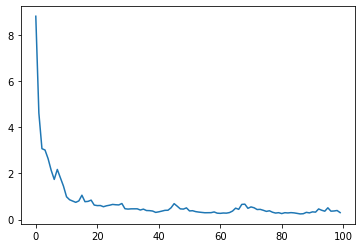

In [13]:
plt.plot(epochs, scores)

In [14]:
model.eval()

AttentiveFP(
  (init_context): GetContext(
    (project_node): Sequential(
      (0): Linear(in_features=39, out_features=200, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (project_edge1): Sequential(
      (0): Linear(in_features=49, out_features=200, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (project_edge2): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=400, out_features=1, bias=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (attentive_gru): AttentiveGRU1(
      (edge_transform): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=200, out_features=200, bias=True)
      )
      (gru): GRUCell(200, 200)
    )
  )
  (gnn_layers): ModuleList(
    (0): GNNLayer(
      (project_edge): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=400, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive

In [15]:
all_pred = []
for test_data in test_loader:
    smi_lst, bg, labels, masks = test_data
    if torch.cuda.is_available():
            bg.to(torch.device('cuda:0'))
            labels = labels.to('cuda:0')
            masks = masks.to('cuda:0')
    pred = model(bg, bg.ndata['hv'], bg.edata['he'])
    all_pred.append(pred.data.cpu().numpy())

In [16]:
res = np.vstack(all_pred)

In [17]:
res.shape

(257, 1)

In [18]:
test_sol.numpy().shape

(257, 1)

Text(0, 0.5, 'exp')

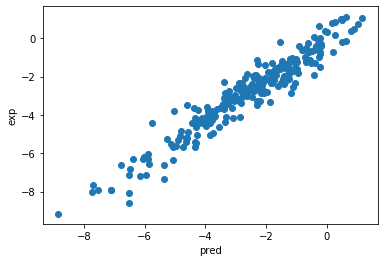

In [19]:
plt.clf()
plt.scatter(res, test_sol)
plt.xlabel('pred')
plt.ylabel('exp')

In [20]:
from sklearn.metrics import r2_score

In [21]:
print(r2_score(test_sol, res))

0.9098691301661277


In [22]:
from sklearn.ensemble import RandomForestRegressor
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

In [23]:
train_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in train_mols]
test_fp = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in test_mols]

In [24]:
rfr = RandomForestRegressor()

In [25]:
rfr.fit(train_fp, train_sol)

/home/takayuki/anaconda3/envs/chemo37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/takayuki/anaconda3/envs/chemo37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
rfr_pred = rfr.predict(test_fp)

In [27]:
r2_score(test_sol, rfr_pred)

0.6846847631483519